In [83]:
import os
import pandas as pd
import geopandas as gpd
import datetime as dt
import contextily as ctx
import matplotlib.pyplot as plt
from shapely.geometry import Polygon
import seaborn as sns
import numpy as np
from tqdm import tqdm
tqdm.pandas()

DROOT = os.path.join('./1-data/')
drootf = lambda path: os.path.join(DROOT, path)
CTX_CRS = 'epsg:3857'
CTX_SRC = ctx.providers.OpenStreetMap.Mapnik


pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 200)

### Postcodes

(4053, 41)


,postcode4,aantal_inwoners,aantal_mannen,aantal_vrouwen,aantal_inwoners_0_tot_15_jaar,aantal_inwoners_15_tot_25_jaar,aantal_inwoners_25_tot_45_jaar,aantal_inwoners_45_tot_65_jaar,aantal_inwoners_65_jaar_en_ouder,percentage_geb_nederland_herkomst_nederland,percentage_geb_nederland_herkomst_overig_europa,percentage_geb_nederland_herkomst_buiten_europa,percentage_geb_buiten_nederland_herkomst_europa,percentage_geb_buiten_nederland_herkmst_buiten_europa,aantal_part_huishoudens,aantal_eenpersoonshuishoudens,aantal_meerpersoonshuishoudens_zonder_kind,aantal_eenouderhuishoudens,aantal_tweeouderhuishoudens,gemiddelde_huishoudensgrootte,aantal_woningen,aantal_woningen_bouwjaar_voor_1945,aantal_woningen_bouwjaar_45_tot_65,aantal_woningen_bouwjaar_65_tot_75,aantal_woningen_bouwjaar_75_tot_85,aantal_woningen_bouwjaar_85_tot_95,aantal_woningen_bouwjaar_95_tot_05,aantal_woningen_bouwjaar_05_tot_15,aantal_woningen_bouwjaar_15_en_later,aantal_meergezins_woningen,percentage_koopwoningen,percentage_huurwoningen,aantal_huurwoningen_in_bezit_woningcorporaties,aantal_niet_bewoonde_woningen,gemiddelde_woz_waarde_woning,aantal_personen_met_uitkering_onder_aowlft,omgevingsadressendichtheid,stedelijkheid,geometry,kmarea,utm_centroid
0,1184.0,625,320,305,100,90,110,215,110,70,10,10,10,10,255,70,70,20,95,2.4,245,165,10,-99997,10,20,10,25,-99997,20,80,20,15,10,902,15,585,4,"MULTIPOLYGON (((629092.107 5795860.327, 629139...",0.121549,POINT (629074.569 5795763.369)


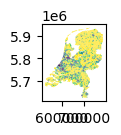

In [4]:
# Load postcodes
postcodes = gpd.read_file(drootf('2023-CBS_pc4_2022_v1/cbs_pc4_2022_v1.gpkg'))
CRS_DEFAULT = postcodes.estimate_utm_crs()
postcodes = postcodes.to_crs(CRS_DEFAULT)

# Set details
postcodes.postcode4 = postcodes.postcode4.astype(float)
postcodes['kmarea'] = postcodes.area / 10e6 # to Km2
postcodes['utm_centroid'] = postcodes.centroid
postcodes = postcodes[postcodes.stedelijkheid > 0] # Some regions with harbours
pc_reduced = postcodes[['postcode4', 'stedelijkheid', 'geometry', 'utm_centroid']]

# Display
ax = postcodes.plot(figsize=(1,1), column='stedelijkheid')
print(postcodes.shape)
postcodes.head(1)

### Weather

,STN,FHVEC,FG,TG,DR,RH,DATE,NAME,geometry
1826,215,58.0,64.0,68.0,35.0,37.0,2018-01-01,Voorschoten,POINT Z (598338.056 5777694.535 -1.100)
1827,215,48.0,63.0,70.0,69.0,54.0,2018-01-02,Voorschoten,POINT Z (598338.056 5777694.535 -1.100)


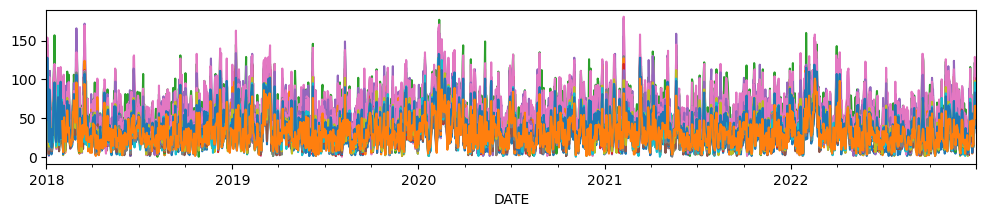

In [5]:
# Load weather stations
stations = pd.read_csv(drootf('./knmi/knmi-stations.csv'), index_col='STN')
stations['geometry'] = gpd.points_from_xy(stations.LON, stations.LAT, stations.ALT, crs='EPSG:4326')
stations = gpd.GeoDataFrame(stations)
stations = stations.to_crs(CRS_DEFAULT)

# Load weather data
knmi_result = pd.read_csv(drootf('./knmi/result.txt'), skiprows=61, skipinitialspace = True)
knmi_result = knmi_result.rename(columns={'# STN': 'STN'})
knmi_result['DATE'] = pd.to_datetime(knmi_result.YYYYMMDD, format="%Y%m%d")
knmi_result = knmi_result.merge(stations[['NAME', 'geometry']], on='STN')
knmi_result = knmi_result.dropna(how='any').drop(columns=['YYYYMMDD'])

# Visualize
knmi_result.sort_values('DATE').pivot_table('FHVEC', 'DATE', 'NAME').plot(figsize=(12,2), legend=False)
knmi_result.head(2)

,postcode4,aantal_inwoners,aantal_mannen,aantal_vrouwen,aantal_inwoners_0_tot_15_jaar,aantal_inwoners_15_tot_25_jaar,aantal_inwoners_25_tot_45_jaar,aantal_inwoners_45_tot_65_jaar,aantal_inwoners_65_jaar_en_ouder,percentage_geb_nederland_herkomst_nederland,percentage_geb_nederland_herkomst_overig_europa,percentage_geb_nederland_herkomst_buiten_europa,percentage_geb_buiten_nederland_herkomst_europa,percentage_geb_buiten_nederland_herkmst_buiten_europa,aantal_part_huishoudens,aantal_eenpersoonshuishoudens,aantal_meerpersoonshuishoudens_zonder_kind,aantal_eenouderhuishoudens,aantal_tweeouderhuishoudens,gemiddelde_huishoudensgrootte,aantal_woningen,aantal_woningen_bouwjaar_voor_1945,aantal_woningen_bouwjaar_45_tot_65,aantal_woningen_bouwjaar_65_tot_75,aantal_woningen_bouwjaar_75_tot_85,aantal_woningen_bouwjaar_85_tot_95,aantal_woningen_bouwjaar_95_tot_05,aantal_woningen_bouwjaar_05_tot_15,aantal_woningen_bouwjaar_15_en_later,aantal_meergezins_woningen,percentage_koopwoningen,percentage_huurwoningen,aantal_huurwoningen_in_bezit_woningcorporaties,aantal_niet_bewoonde_woningen,gemiddelde_woz_waarde_woning,aantal_personen_met_uitkering_onder_aowlft,omgevingsadressendichtheid,stedelijkheid,geometry,kmarea,utm_centroid,index_knmi,LON,LAT,ALT,NAME
0,1184.0,625,320,305,100,90,110,215,110,70,10,10,10,10,255,70,70,20,95,2.4,245,165,10,-99997,10,20,10,25,-99997,20,80,20,15,10,902,15,585,4,"MULTIPOLYGON (((629092.107 5795860.327, 629139...",0.121549,POINT (629074.569 5795763.369),240,4.79,52.318,-3.3,Schiphol
5,1381.0,4950,2370,2580,675,490,980,1530,1275,80,0,10,0,10,2400,960,755,150,535,2.0,2440,1055,485,265,200,280,75,75,5,810,50,40,695,115,462,300,1764,2,"MULTIPOLYGON (((638312.216 5796620.049, 638373...",0.870897,POINT (641374.247 5796554.651),240,4.79,52.318,-3.3,Schiphol


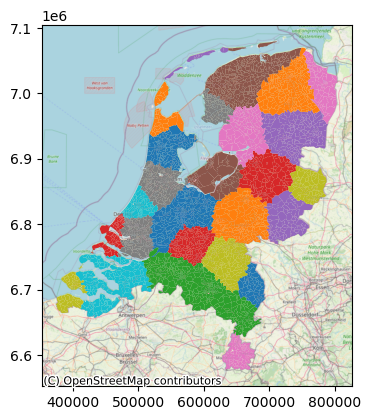

In [6]:
# Filter stations df to only have complete stations, and attach those stations to postcode4 zones.
stations_f = stations[stations.index.isin(knmi_result.STN.unique())]
postcodes_knmi = postcodes.set_geometry('utm_centroid').sjoin_nearest(stations_f, rsuffix='knmi')

# Display
fig, ax = plt.subplots(figsize=(4,8))
postcodes_knmi.set_geometry('geometry').to_crs(CTX_CRS).plot(column='NAME', ax=ax)
ctx.add_basemap(ax=ax, source=CTX_SRC)
postcodes_knmi.head(2)

### BAG Information

,identificatie,oppervlakte,nummeraanduiding_id,pand_id,pand_id_geom,StatusCode,BEGINDATUM,EINDDATUM,VOORKOMENIDENTIFICATIE,TIJDSTIPREGISTRATIE,EINDREGISTRATIE,DOCUMENTDATUM,DOCUMENTNUMMER,bijeenkomst,cel,gezondheidszorg,industrie,kantoor,logies,onderwijs,overige_gebruiks,sport,winkel,woon,geometry
0,0000010000057469,72,0000200000057534,1883100000010452,1883100000010452,5,20180404,0,2,2018-04-04T11:59:28.000,,20180404,correctie,False,False,False,False,False,False,False,False,False,False,True,POINT (188391.891 334586.438)
1,0003010000125985,69,0003200000134057,0003100000122770,0003100000122770,4,20100720,0,1,2010-10-20T08:43:37.000,,20100720,FB 2010/PANDEN001,False,False,False,False,False,False,False,False,False,False,True,POINT (252767.344 593745.500)


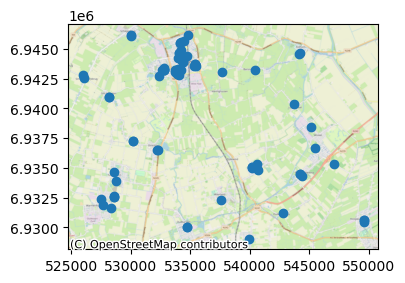

In [8]:
# Show sample
sample = bag_gdf[bag_gdf.within(mask.to_crs(bag_gdf.crs).iloc[0])]
ax = sample[sample.onderwijs].to_crs(CTX_CRS).plot(figsize=(4, 4))
ctx.add_basemap(ax=ax, source=CTX_SRC)
bag_gdf.head(2)

### Load Isochrones

In [9]:
iso_gdf = pd.read_pickle(drootf('pc_gdf_reach.pcl'))
iso_gdf = gpd.GeoDataFrame(iso_gdf).set_geometry('isochrone')
iso_gdf.head(2)

,uid,pid,startpt,trmode,tt_mnts,dep_dt,source,city_id,isochrone,cache_avail,index_right,postcode4,aantal_inwoners,aantal_mannen,aantal_vrouwen,aantal_inwoners_0_tot_15_jaar,aantal_inwoners_15_tot_25_jaar,aantal_inwoners_25_tot_45_jaar,aantal_inwoners_45_tot_65_jaar,aantal_inwoners_65_jaar_en_ouder,percentage_geb_nederland_herkomst_nederland,percentage_geb_nederland_herkomst_overig_europa,percentage_geb_nederland_herkomst_buiten_europa,percentage_geb_buiten_nederland_herkomst_europa,percentage_geb_buiten_nederland_herkmst_buiten_europa,aantal_part_huishoudens,aantal_eenpersoonshuishoudens,aantal_meerpersoonshuishoudens_zonder_kind,aantal_eenouderhuishoudens,aantal_tweeouderhuishoudens,gemiddelde_huishoudensgrootte,aantal_woningen,aantal_woningen_bouwjaar_voor_1945,aantal_woningen_bouwjaar_45_tot_65,aantal_woningen_bouwjaar_65_tot_75,aantal_woningen_bouwjaar_75_tot_85,aantal_woningen_bouwjaar_85_tot_95,aantal_woningen_bouwjaar_95_tot_05,aantal_woningen_bouwjaar_05_tot_15,aantal_woningen_bouwjaar_15_en_later,aantal_meergezins_woningen,percentage_koopwoningen,percentage_huurwoningen,aantal_huurwoningen_in_bezit_woningcorporaties,aantal_niet_bewoonde_woningen,gemiddelde_woz_waarde_woning,aantal_personen_met_uitkering_onder_aowlft,omgevingsadressendichtheid,stedelijkheid,geometry,kmarea,centroid_utm
0,NL-0-transit_off-30m-g,0,POINT (4.89239 52.29702),transit_off,30,2023-10-03 08:30:00+02:00,g,NL,"POLYGON ((4.77416 52.78650, 4.77416 52.78650, ...",True,0,1184,625,320,305,100,90,110,215,110,70,10,10,10,10,255,70,70,20,95,2.4,245,165,10,-99997,10,20,10,25,-99997,20,80,20,15,10,902,15,585,4,"MULTIPOLYGON (((121294.892 478995.293, 121341....",0.121549,POINT (4.89281 52.29704)
1,NL-0-transit_bike_off-30m-g,0,POINT (4.89239 52.29702),transit_bike_off,30,2023-10-03 08:30:00+02:00,g,NL,"MULTIPOLYGON (((4.90843 52.79254, 4.90843 52.7...",True,0,1184,625,320,305,100,90,110,215,110,70,10,10,10,10,255,70,70,20,95,2.4,245,165,10,-99997,10,20,10,25,-99997,20,80,20,15,10,902,15,585,4,"MULTIPOLYGON (((121294.892 478995.293, 121341....",0.121549,POINT (4.89281 52.29704)


In [94]:
iso_gdf_sample = iso_gdf.iloc[:5]
iso_gdf_sample['isochrone'] = iso_gdf_sample.to_crs(CRS_DEFAULT).buffer(50)
iso_gdf_sample.head(2)

/Users/ivo/mambaforge/envs/thesis-env/lib/python3.11/site-packages/geopandas/geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


,uid,pid,startpt,trmode,tt_mnts,dep_dt,source,city_id,isochrone,cache_avail,index_right,postcode4,aantal_inwoners,aantal_mannen,aantal_vrouwen,aantal_inwoners_0_tot_15_jaar,aantal_inwoners_15_tot_25_jaar,aantal_inwoners_25_tot_45_jaar,aantal_inwoners_45_tot_65_jaar,aantal_inwoners_65_jaar_en_ouder,percentage_geb_nederland_herkomst_nederland,percentage_geb_nederland_herkomst_overig_europa,percentage_geb_nederland_herkomst_buiten_europa,percentage_geb_buiten_nederland_herkomst_europa,percentage_geb_buiten_nederland_herkmst_buiten_europa,aantal_part_huishoudens,aantal_eenpersoonshuishoudens,aantal_meerpersoonshuishoudens_zonder_kind,aantal_eenouderhuishoudens,aantal_tweeouderhuishoudens,gemiddelde_huishoudensgrootte,aantal_woningen,aantal_woningen_bouwjaar_voor_1945,aantal_woningen_bouwjaar_45_tot_65,aantal_woningen_bouwjaar_65_tot_75,aantal_woningen_bouwjaar_75_tot_85,aantal_woningen_bouwjaar_85_tot_95,aantal_woningen_bouwjaar_95_tot_05,aantal_woningen_bouwjaar_05_tot_15,aantal_woningen_bouwjaar_15_en_later,aantal_meergezins_woningen,percentage_koopwoningen,percentage_huurwoningen,aantal_huurwoningen_in_bezit_woningcorporaties,aantal_niet_bewoonde_woningen,gemiddelde_woz_waarde_woning,aantal_personen_met_uitkering_onder_aowlft,omgevingsadressendichtheid,stedelijkheid,geometry,kmarea,centroid_utm
0,NL-0-transit_off-30m-g,0,POINT (4.89239 52.29702),transit_off,30,2023-10-03 08:30:00+02:00,g,NL,"POLYGON ((619599.839 5850014.811, 619600.828 5...",True,0,1184,625,320,305,100,90,110,215,110,70,10,10,10,10,255,70,70,20,95,2.4,245,165,10,-99997,10,20,10,25,-99997,20,80,20,15,10,902,15,585,4,"MULTIPOLYGON (((121294.892 478995.293, 121341....",0.121549,POINT (4.89281 52.29704)
1,NL-0-transit_bike_off-30m-g,0,POINT (4.89239 52.29702),transit_bike_off,30,2023-10-03 08:30:00+02:00,g,NL,"MULTIPOLYGON (((628635.629 5850927.026, 628635...",True,0,1184,625,320,305,100,90,110,215,110,70,10,10,10,10,255,70,70,20,95,2.4,245,165,10,-99997,10,20,10,25,-99997,20,80,20,15,10,902,15,585,4,"MULTIPOLYGON (((121294.892 478995.293, 121341....",0.121549,POINT (4.89281 52.29704)
2,NL-0-driving_off-25m-g,0,POINT (4.89239 52.29702),driving_off,25,2023-10-03 08:30:00+02:00,g,NL,"POLYGON ((610495.336 5831396.313, 610495.252 5...",True,0,1184,625,320,305,100,90,110,215,110,70,10,10,10,10,255,70,70,20,95,2.4,245,165,10,-99997,10,20,10,25,-99997,20,80,20,15,10,902,15,585,4,"MULTIPOLYGON (((121294.892 478995.293, 121341....",0.121549,POINT (4.89281 52.29704)
3,NL-0-cycling-30m-g,0,POINT (4.89239 52.29702),cycling,30,2023-10-03 08:30:00+02:00,g,NL,"POLYGON ((614507.253 5850016.565, 614503.609 5...",True,0,1184,625,320,305,100,90,110,215,110,70,10,10,10,10,255,70,70,20,95,2.4,245,165,10,-99997,10,20,10,25,-99997,20,80,20,15,10,902,15,585,4,"MULTIPOLYGON (((121294.892 478995.293, 121341....",0.121549,POINT (4.89281 52.29704)
4,NL-0-walking-30m-g,0,POINT (4.89239 52.29702),walking,30,2023-10-03 08:30:00+02:00,g,NL,"POLYGON ((619633.748 5849983.891, 619633.764 5...",True,0,1184,625,320,305,100,90,110,215,110,70,10,10,10,10,255,70,70,20,95,2.4,245,165,10,-99997,10,20,10,25,-99997,20,80,20,15,10,902,15,585,4,"MULTIPOLYGON (((121294.892 478995.293, 121341....",0.121549,POINT (4.89281 52.29704)


In [96]:
coords = [(4.723223399790179, 52.82387348804171), 
                (4.943932049601555, 52.819746789026915), 
                (4.938184404627946, 52.69718243028993), 
                (4.711532182168482, 52.716038791893496)]
mask = gpd.GeoSeries(Polygon(coords), crs="EPSG:4326").to_crs(CRS_DEFAULT)

In [110]:
facilities = iso_gdf_sample.isochrone.progress_apply(lambda x: bag_gdf[bag_gdf.within(x)][uses_list].sum().tolist())
facilities

100%|██████████| 5/5 [05:49<00:00, 69.80s/it] 


0    [131, 0, 188, 463, 294, 12, 34, 841, 26, 309, ...
1    [259, 0, 259, 1600, 370, 1450, 58, 1244, 43, 4...
2    [2719, 5, 1877, 14078, 4108, 9573, 536, 14402,...
3    [260, 0, 259, 1746, 388, 1330, 58, 1263, 46, 4...
4    [133, 0, 188, 484, 295, 14, 34, 841, 26, 309, ...
dtype: object

### ODiN Data Loading

In [34]:
KHvm_t = {
    "1": "Personenauto - bestuurder",
    "2": "Personenauto - passagier",
    "3": "Trein",
    "4": "Bus/tram/metro",
    "5": "Fiets",
    "6": "Te voet",
    "7": "Overig",
}

In [47]:
odin_df = pd.concat([
    pd.read_csv(drootf('ODiN/ODiN2021_Databestand.csv'), sep=';', encoding='unicode_escape'),
    pd.read_csv(drootf('ODiN/ODiN2022_Databestand.csv'), sep=';', encoding='unicode_escape'),
    pd.read_csv(drootf('ODiN/ODiN2018_Databestand_v2.0.csv'), sep=';', encoding='unicode_escape'),
    pd.read_csv(drootf('ODiN/ODiN2019_Databestand_v2.0.csv'), sep=';', encoding='unicode_escape')
])
odin_df = odin_df.drop_duplicates('VerplID')
odin_df['ReportDate'] = pd.to_datetime(dict(year=odin_df.Jaar, month=odin_df.Maand, day=odin_df.Dag))
odin_df['KHvm_t'] = odin_df.KHvm.replace(KHvm_t)
odin_df.head(2)

/var/folders/kw/9t0kx7hd0g15xn5ntmxsgvvw0000gp/T/ipykernel_12986/1764763653.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  odin_df['ReportDate'] = pd.to_datetime(dict(year=odin_df.Jaar, month=odin_df.Maand, day=odin_df.Dag))
/var/folders/kw/9t0kx7hd0g15xn5ntmxsgvvw0000gp/T/ipykernel_12986/1764763653.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  odin_df['KHvm_t'] = odin_df.KHvm.replace(KHvm_t)


,OP,OPID,Steekproef,Mode,HHPers,HHSam,HHPlOP,HHLft1,HHLft2,HHLft3,HHLft4,WoPC,WoGem,Sted,GemGr,Prov,Corop,BuurtAdam,MRA,MRDH,Utr,Geslacht,Leeftijd,KLeeft,Herkomst,BetWerk,OnbBez,MaatsPart,Opleiding,HHBestInkG,HHGestInkG,HHLaagInk,HHSocInk,HHWelvG,HHRijbewijsAu,HHRijbewijsMo,HHRijbewijsBr,OPRijbewijsAu,OPRijbewijsMo,OPRijbewijsBr,HHAuto,HHAutoL,OPAuto,BrandstofPa1,XBrandstofPa1,BrandstofEPa1,BouwjaarPa1,KBouwjaarPa1,KGewichtPa1,TenaamPa1,BrandstofPa2,XBrandstofPa2,BrandstofEPa2,BouwjaarPa2,KBouwjaarPa2,KGewichtPa2,TenaamPa2,BrandstofPaL,XBrandstofPaL,BrandstofEPaL,BouwjaarPaL,KBouwjaarPaL,KGewichtPaL,HHMotor,OPMotor,HHBrom,OPBrom,HHSnor,OPSnor,HHEFiets,HHBezitVm,OPBezitVm,FqLopen,FqNEFiets,FqEFiets,FqBTM,FqTrein,FqAutoB,FqAutoP,FqBrSnor,FqMotor,OVStKaart,Jaar,Maand,Week,Dag,Weekdag,Feestdag,Weggeweest,RedenNW,RedenNWZ,RedenNWW,RedenNWB,AantVpl,AantOVVpl,AantSVpl,EFiets,AutoEig,AutoHhL,AutoLWg,AutoLPl,AutoBed,AutoDOrg,AutoDPart,AutoDBek,AutoLeen,AutoHuur,AutoAnd,ByzDag,ByzAdr,ByzVvm,ByzTyd,ByzDuur,ByzRoute,ByzReden,ReisduurOP,AfstandOP,AfstandSOP,Verpl,VerplID,VerplNr,Toer,AantRit,Doel,MotiefV,KMotiefV,MeerWink,AardWerk,VertLoc,VertGeb,VertPC,VertPCBL,VertGem,VertProv,VertCorop,VertMRA,VertMRDH,VertUtr,AankGeb,AankPC,AankPCBL,AankGem,AankProv,AankCorop,AankMRA,AankMRDH,AankUtr,PCG,GemG,PCBLG,AfstV,KAfstV,Hvm,HvmRol,KHvm,VertUur,VertMin,KVertTijd,AankUur,AankMin,Reisduur,KReisduur,ActDuur,Kind6,VolgWerk,SAantAdr,SDezPlts,SPlaats1,SPlaats2,SPlaats3,SPlaats4,SPlaats5,AfstS,AfstSBL,SVvm1,SVvm2,SVvm3,SVvm4,SBegUur,SBegMin,SEindUur,SEindMin,CorrVerpl,GehBLVer,Rit,RitID,RitNr,AfstR,AfstRBL,KAfstR,Rvm,RvmRol,RAantIn,KRvm,RVertUur,RVertMin,RAankUur,RAankMin,RReisduur,RReisduurBL,RVertStat,RAankStat,RTSamen,RCorrSnelh,RVliegVer,FactorH,FactorP,FactorV,WrkVervw,WrkVerg,VergVast,VergKm,VergBrSt,VergOV,VergAans,VergVoer,VergBudg,VergPark,VergStal,VergAnd,BerWrk,RdWrkA,RdWrkB,BerOnd,RdOndA,RdOndB,BerSup,RdSupA,RdSupB,BerZiek,RdZiekA,RdZiekB,BerArts,RdArtsA,RdArtsB,BerStat,RdStatA,RdStatB,BerHalte,RdHalteA,RdHalteB,BerFam,RdFamA,RdFamB,BerSport,RdSportA,RdSportB,ReportDate,KHvm_t
0,1,62344107254,1,1,3,3,3,1,0,0,2,1363,34,2,7,5,40,0,15,18.0,21.0,2,38,9,1,3,0,2,4,10,10,8,9,9,2,0,2,1,0,1,2,1,1,2,0,0,2011,2,3,1,7,7,6,9995,9,7,3,1,0,0,2018,4,3,0,0,0,0,0,0,0,2,3,9.0,3,5,5,5,2,2,5,9.0,0,2021,1,2,17,1,0,1,0,0,0,0,2,0,0,5,2,2,1,2,2,2,2,2,2,2,2,2,3,3,3,3,3,11,30,150,0,1,6234410725401,1,0,1,9,8,6,3,12,1,0,1363.0,1.0,34,5,40,15,18,21,0,1319.0,1.0,34,5,40,15,18,21,0.0,0,0.0,75,7,1,2,2,16,0,9,16,15,15,4,210,1,9,#NULL!,#NULL!,NaN,NaN,NaN,NaN,NaN,#NULL!,#NULL!,#NULL!,#NULL!,#NULL!,#NULL!,#NULL!,#NULL!,#NULL!,#NULL!,0,0,1,623441072540101,1,75,0,7,1,2,3,2,16,0,16,15,15,0,0.0,0.0,13,0,0,94,188,68606,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021-01-17,Personenauto - passagier
1,0,62344107254,1,1,3,3,3,1,0,0,2,1363,34,2,7,5,40,0,15,18.0,21.0,2,38,9,1,3,0,2,4,10,10,8,9,9,2,0,2,1,0,1,2,1,1,2,0,0,2011,2,3,1,7,7,6,9995,9,7,3,1,0,0,2018,4,3,0,0,0,0,0,0,0,2,3,9.0,3,5,5,5,2,2,5,9.0,0,2021,1,2,17,1,0,1,0,0,0,0,2,0,0,5,2,2,1,2,2,2,2,2,2,2,2,2,3,3,3,3,3,11,30,150,0,1,6234410725402,2,0,1,1,8,6,3,12,4,0,1319.0,1.0,34,5,40,15,18,21,0,1363.0,1.0,34,5,40,15,18,21,0.0,0,0.0,75,7,1,2,2,19,45,12,20,0,15,4,#NULL!,1,9,#NULL!,#NULL!,NaN,NaN,NaN,NaN,NaN,#NULL!,#NULL!,#NULL!,#NULL!,#NULL!,#NULL!,#NULL!,#NULL!,#NULL!,#NULL!,0,0,1,623441072540201,1,75,0,7,1,2,3,2,19,45,20,0,15,0,0.0,0.0,13,0,0,94,188,68606,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021-01-17,Personenauto - passagier


In [48]:
odin_df_r = odin_df.merge(postcodes_knmi, left_on='VertPC', right_on='postcode4')
odin_df_r = odin_df_r.merge(knmi_result, left_on=['ReportDate', 'index_knmi'], right_on=['DATE', 'STN'])
odin_df_r.head(2)

,OP,OPID,Steekproef,Mode,HHPers,HHSam,HHPlOP,HHLft1,HHLft2,HHLft3,HHLft4,WoPC,WoGem,Sted,GemGr,Prov,Corop,BuurtAdam,MRA,MRDH,Utr,Geslacht,Leeftijd,KLeeft,Herkomst,BetWerk,OnbBez,MaatsPart,Opleiding,HHBestInkG,HHGestInkG,HHLaagInk,HHSocInk,HHWelvG,HHRijbewijsAu,HHRijbewijsMo,HHRijbewijsBr,OPRijbewijsAu,OPRijbewijsMo,OPRijbewijsBr,HHAuto,HHAutoL,OPAuto,BrandstofPa1,XBrandstofPa1,BrandstofEPa1,BouwjaarPa1,KBouwjaarPa1,KGewichtPa1,TenaamPa1,BrandstofPa2,XBrandstofPa2,BrandstofEPa2,BouwjaarPa2,KBouwjaarPa2,KGewichtPa2,TenaamPa2,BrandstofPaL,XBrandstofPaL,BrandstofEPaL,BouwjaarPaL,KBouwjaarPaL,KGewichtPaL,HHMotor,OPMotor,HHBrom,OPBrom,HHSnor,OPSnor,HHEFiets,HHBezitVm,OPBezitVm,FqLopen,FqNEFiets,FqEFiets,FqBTM,FqTrein,FqAutoB,FqAutoP,FqBrSnor,FqMotor,OVStKaart,Jaar,Maand,Week,Dag,Weekdag,Feestdag,Weggeweest,RedenNW,RedenNWZ,RedenNWW,RedenNWB,AantVpl,AantOVVpl,AantSVpl,EFiets,AutoEig,AutoHhL,AutoLWg,AutoLPl,AutoBed,AutoDOrg,AutoDPart,AutoDBek,AutoLeen,AutoHuur,AutoAnd,ByzDag,ByzAdr,ByzVvm,ByzTyd,ByzDuur,ByzRoute,ByzReden,ReisduurOP,AfstandOP,AfstandSOP,Verpl,VerplID,VerplNr,Toer,AantRit,Doel,MotiefV,KMotiefV,MeerWink,AardWerk,VertLoc,VertGeb,VertPC,VertPCBL,VertGem,VertProv,VertCorop,VertMRA,VertMRDH,VertUtr,AankGeb,AankPC,AankPCBL,AankGem,AankProv,AankCorop,AankMRA,AankMRDH,AankUtr,PCG,GemG,PCBLG,AfstV,KAfstV,Hvm,HvmRol,KHvm,VertUur,VertMin,KVertTijd,AankUur,AankMin,Reisduur,KReisduur,ActDuur,Kind6,VolgWerk,SAantAdr,SDezPlts,SPlaats1,SPlaats2,SPlaats3,SPlaats4,SPlaats5,AfstS,AfstSBL,SVvm1,SVvm2,SVvm3,SVvm4,SBegUur,SBegMin,SEindUur,SEindMin,CorrVerpl,GehBLVer,Rit,RitID,RitNr,AfstR,AfstRBL,KAfstR,Rvm,RvmRol,RAantIn,KRvm,RVertUur,RVertMin,RAankUur,RAankMin,RReisduur,RReisduurBL,RVertStat,RAankStat,RTSamen,RCorrSnelh,RVliegVer,FactorH,FactorP,FactorV,WrkVervw,WrkVerg,VergVast,VergKm,VergBrSt,VergOV,VergAans,VergVoer,VergBudg,VergPark,VergStal,VergAnd,BerWrk,RdWrkA,RdWrkB,BerOnd,RdOndA,RdOndB,BerSup,RdSupA,RdSupB,BerZiek,RdZiekA,RdZiekB,BerArts,RdArtsA,RdArtsB,BerStat,RdStatA,RdStatB,BerHalte,RdHalteA,RdHalteB,BerFam,RdFamA,RdFamB,BerSport,RdSportA,RdSportB,ReportDate,KHvm_t,postcode4,aantal_inwoners,aantal_mannen,aantal_vrouwen,aantal_inwoners_0_tot_15_jaar,aantal_inwoners_15_tot_25_jaar,aantal_inwoners_25_tot_45_jaar,aantal_inwoners_45_tot_65_jaar,aantal_inwoners_65_jaar_en_ouder,percentage_geb_nederland_herkomst_nederland,percentage_geb_nederland_herkomst_overig_europa,percentage_geb_nederland_herkomst_buiten_europa,percentage_geb_buiten_nederland_herkomst_europa,percentage_geb_buiten_nederland_herkmst_buiten_europa,aantal_part_huishoudens,aantal_eenpersoonshuishoudens,aantal_meerpersoonshuishoudens_zonder_kind,aantal_eenouderhuishoudens,aantal_tweeouderhuishoudens,gemiddelde_huishoudensgrootte,aantal_woningen,aantal_woningen_bouwjaar_voor_1945,aantal_woningen_bouwjaar_45_tot_65,aantal_woningen_bouwjaar_65_tot_75,aantal_woningen_bouwjaar_75_tot_85,aantal_woningen_bouwjaar_85_tot_95,aantal_woningen_bouwjaar_95_tot_05,aantal_woningen_bouwjaar_05_tot_15,aantal_woningen_bouwjaar_15_en_later,aantal_meergezins_woningen,percentage_koopwoningen,percentage_huurwoningen,aantal_huurwoningen_in_bezit_woningcorporaties,aantal_niet_bewoonde_woningen,gemiddelde_woz_waarde_woning,aantal_personen_met_uitkering_onder_aowlft,omgevingsadressendichtheid,stedelijkheid,geometry_x,kmarea,utm_centroid,index_knmi,LON,LAT,ALT,NAME_x,STN,FHVEC,FG,TG,DR,RH,DATE,NAME_y,geometry_y
0,1,62344107254,1,1,3,3,3,1,0,0,2,1363,34,2,7,5,40,0,15,18.0,21.0,2,38,9,1,3,0,2,4,10,10,8,9,9,2,0,2,1,0,1,2,1,1,2,0,0,2011,2,3,1,7,7,6,9995,9,7,3,1,0,0,2018,4,3,0,0,0,0,0,0,0,2,3,9.0,3,5,5,5,2,2,5,9.0,0,2021,1,2,17,1,0,1,0,0,0,0,2,0,0,5,2,2,1,2,2,2,2,2,2,2,2,2,3,3,3,3,3,11,30,150,0,1,6234410725401,1,0,1,9,8,6,3,12,1,0,1363.0,1.0,34,5,40,15,18,21,0,1319.0,1.0,34,5,40,15,18,21,0.0,0,0.0,75,7,1,2,2,16,0,9,16,15,15,4,210,1,9,#NULL!,#NULL!,NaN,NaN,NaN,NaN,NaN,#NULL!,#NULL!,#NULL!,#NULL!,#NULL!,#NULL!,#NULL!,#NULL!,#NULL!,#NULL!,0,0,1,623441072540101,1,75,0,7,1,2,3,2,16,0,16,15,15,0,0.0,0.0,13,

(648589, 304) (196079, 304)


,VertPC,Bus/tram/metro,Fiets,Overig,Personenauto - bestuurder,Personenauto - passagier,Te voet,Trein,trips_n,trips_n_unweighted,postcode4,aantal_inwoners,aantal_mannen,aantal_vrouwen,aantal_inwoners_0_tot_15_jaar,aantal_inwoners_15_tot_25_jaar,aantal_inwoners_25_tot_45_jaar,aantal_inwoners_45_tot_65_jaar,aantal_inwoners_65_jaar_en_ouder,percentage_geb_nederland_herkomst_nederland,percentage_geb_nederland_herkomst_overig_europa,percentage_geb_nederland_herkomst_buiten_europa,percentage_geb_buiten_nederland_herkomst_europa,percentage_geb_buiten_nederland_herkmst_buiten_europa,aantal_part_huishoudens,aantal_eenpersoonshuishoudens,aantal_meerpersoonshuishoudens_zonder_kind,aantal_eenouderhuishoudens,aantal_tweeouderhuishoudens,gemiddelde_huishoudensgrootte,aantal_woningen,aantal_woningen_bouwjaar_voor_1945,aantal_woningen_bouwjaar_45_tot_65,aantal_woningen_bouwjaar_65_tot_75,aantal_woningen_bouwjaar_75_tot_85,aantal_woningen_bouwjaar_85_tot_95,aantal_woningen_bouwjaar_95_tot_05,aantal_woningen_bouwjaar_05_tot_15,aantal_woningen_bouwjaar_15_en_later,aantal_meergezins_woningen,percentage_koopwoningen,percentage_huurwoningen,aantal_huurwoningen_in_bezit_woningcorporaties,aantal_niet_bewoonde_woningen,gemiddelde_woz_waarde_woning,aantal_personen_met_uitkering_onder_aowlft,omgevingsadressendichtheid,stedelijkheid,geometry,kmarea,utm_centroid,index_knmi,LON,LAT,ALT,NAME
0,1011.0,1294196.0,6103477.0,484708.0,968216.0,500797.0,3626128.0,657031.0,13634553.0,105.0,1011.0,9760,5105,4655,710,1180,3375,2580,1915,50,10,10,20,20,6375,4060,1485,335,490,1.5,6250,3365,150,175,900,575,630,395,60,6055,30,70,2450,675,509,715,7084,1,"MULTIPOLYGON (((629600.927 5803127.429, 629612...",0.102226,POINT (629710.882 5804072.182),240,4.79,52.318,-3.3,Schiphol
1,1012.0,3078298.0,4252700.0,745997.0,1105159.0,530527.0,2935109.0,1429498.0,14077288.0,116.0,1012.0,8800,4840,3965,370,1690,4250,1725,770,40,0,10,30,20,6275,4255,1595,175,255,1.4,6005,4955,25,55,145,450,225,110,45,5695,20,80,715,1070,480,610,8578,1,"MULTIPOLYGON (((629542.174 5805094.795, 629614...",0.118491,POINT (629085.744 5804402.365),240,4.79,52.318,-3.3,Schiphol
2,1013.0,1508112.0,9906236.0,1002410.0,2102813.0,1446536.0,6821894.0,2446106.0,25234107.0,219.0,1013.0,21940,10945,10995,2310,2415,7875,5940,3395,50,0,10,10,20,13470,8285,2865,930,1390,1.6,12560,6785,210,120,1645,1540,470,1290,500,12400,30,70,6385,765,471,2525,6581,1,"MULTIPOLYGON (((627415.004 5808131.642, 627808...",0.474622,POINT (627517.483 5806838.586),240,4.79,52.318,-3.3,Schiphol


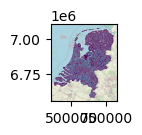

In [53]:
# Drop all non-unique trips. 
df1 = odin_df_r[odin_df_r.VerplNr == '1']
print(odin_df_r.shape, df1.shape)

# Create weighted sums
query_u = df1.pivot_table(index='VertPC', columns='KHvm_t', aggfunc='count', values='AankGem', fill_value=0.) # Unweighted
query   = df1.pivot_table(index='VertPC', columns='KHvm_t', aggfunc='sum', values='FactorV', fill_value=0.) # Weighted
modes = list(query.columns)

# Calculate trip number.
query['trips_n']            = query.sum(axis=1)
query['trips_n_unweighted'] = query_u.sum(axis=1)
query = query.reset_index()

query = gpd.GeoDataFrame(pd.merge(query, postcodes_knmi, left_on='VertPC', right_on='postcode4', how='left')) # Change to outer to include all postal codes
query.trips_n = query.trips_n.fillna(0)

ax = query.to_crs(epsg=3857).plot(column='trips_n', figsize=(1,1))
ctx.add_basemap(ax, source=CTX_SRC, attribution="")

query.head(3)

In [ ]:
pd.DataFrame()

Of all PC4 areas, 54.9% have less than 40 trips departing.


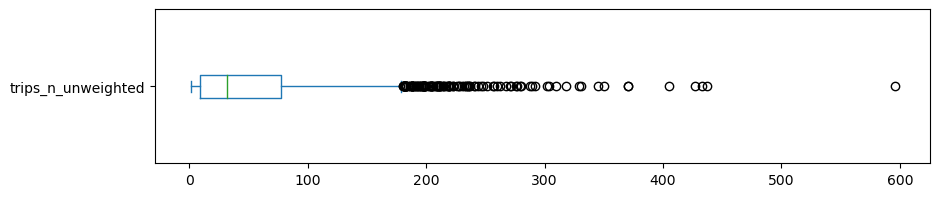

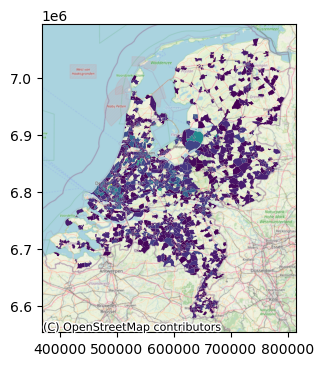

In [68]:
thresh = 40
perc_unavailable = (query.trips_n_unweighted < thresh).sum() / len(query.trips_n_unweighted) * 100
query.trips_n_unweighted.plot.box(vert=False, figsize=(10,2), whis=1.5)

query_f = query[query.trips_n_unweighted >= thresh]
print(f"Of all PC4 areas, {perc_unavailable:.1f}% have less than {thresh} trips departing.")

ax = query_f.to_crs(epsg=3857).plot(column='trips_n_unweighted', figsize=(4,4))
ctx.add_basemap(ax, source=CTX_SRC)

In [70]:
query_f1 = query_f.copy()
query_f1[modes] = query_f1[modes].div(query_f1[modes].sum(axis=1), axis=0)
query_f1['check'] = 1-np.abs(query_f1[modes].sum(axis=1)) < 0.01
query_f1[modes] = query_f1[modes].fillna(0.0)
query_f1.head(2)

,VertPC,Bus/tram/metro,Fiets,Overig,Personenauto - bestuurder,Personenauto - passagier,Te voet,Trein,trips_n,trips_n_unweighted,postcode4,aantal_inwoners,aantal_mannen,aantal_vrouwen,aantal_inwoners_0_tot_15_jaar,aantal_inwoners_15_tot_25_jaar,aantal_inwoners_25_tot_45_jaar,aantal_inwoners_45_tot_65_jaar,aantal_inwoners_65_jaar_en_ouder,percentage_geb_nederland_herkomst_nederland,percentage_geb_nederland_herkomst_overig_europa,percentage_geb_nederland_herkomst_buiten_europa,percentage_geb_buiten_nederland_herkomst_europa,percentage_geb_buiten_nederland_herkmst_buiten_europa,aantal_part_huishoudens,aantal_eenpersoonshuishoudens,aantal_meerpersoonshuishoudens_zonder_kind,aantal_eenouderhuishoudens,aantal_tweeouderhuishoudens,gemiddelde_huishoudensgrootte,aantal_woningen,aantal_woningen_bouwjaar_voor_1945,aantal_woningen_bouwjaar_45_tot_65,aantal_woningen_bouwjaar_65_tot_75,aantal_woningen_bouwjaar_75_tot_85,aantal_woningen_bouwjaar_85_tot_95,aantal_woningen_bouwjaar_95_tot_05,aantal_woningen_bouwjaar_05_tot_15,aantal_woningen_bouwjaar_15_en_later,aantal_meergezins_woningen,percentage_koopwoningen,percentage_huurwoningen,aantal_huurwoningen_in_bezit_woningcorporaties,aantal_niet_bewoonde_woningen,gemiddelde_woz_waarde_woning,aantal_personen_met_uitkering_onder_aowlft,omgevingsadressendichtheid,stedelijkheid,geometry,kmarea,utm_centroid,index_knmi,LON,LAT,ALT,NAME,check
0,1011.0,0.094920,0.447648,0.035550,0.071012,0.036730,0.265951,0.048189,13634553.0,105.0,1011.0,9760,5105,4655,710,1180,3375,2580,1915,50,10,10,20,20,6375,4060,1485,335,490,1.5,6250,3365,150,175,900,575,630,395,60,6055,30,70,2450,675,509,715,7084,1,"MULTIPOLYGON (((629600.927 5803127.429, 629612...",0.102226,POINT (629710.882 5804072.182),240,4.79,52.318,-3.3,Schiphol,True
1,1012.0,0.218671,0.302097,0.052993,0.078507,0.037687,0.208500,0.101546,14077288.0,116.0,1012.0,8800,4840,3965,370,1690,4250,1725,770,40,0,10,30,20,6275,4255,1595,175,255,1.4,6005,4955,25,55,145,450,225,110,45,5695,20,80,715,1070,480,610,8578,1,"MULTIPOLYGON (((629542.174 5805094.795, 629614...",0.118491,POINT (629085.744 5804402.365),240,4.79,52.318,-3.3,Schiphol,True


Text(0.5, 1.0, 'Modal split departing postal code')

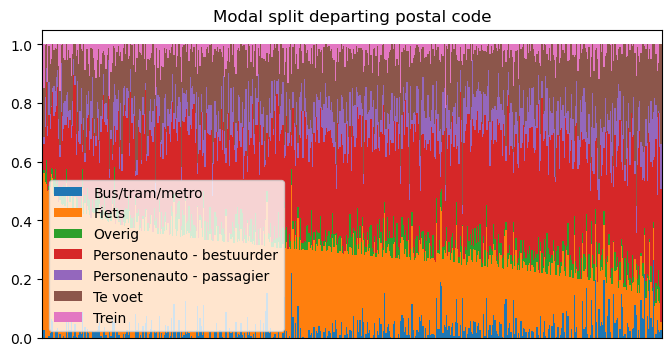

In [71]:
ax = query_f1.sample(500)[modes].sort_values('Fiets', ascending=False).plot.bar(stacked=True, width=1, figsize=(8, 4))
ax.set_xticks([])
ax.set_title("Modal split departing postal code")

In [30]:
modal_split_f

KHvm_transl,Bus/tram/metro,Fiets,Overig,Personenauto - bestuurder,Personenauto - passagier,Te voet,Trein,check
VertPC,,,,,,,,
1011.0,0.030171,0.427708,0.022498,0.093759,0.049876,0.322653,0.053336,True
1012.0,0.143254,0.290489,0.068151,0.068105,0.018981,0.222817,0.188204,True
1013.0,0.037200,0.312727,0.034712,0.111874,0.055747,0.395746,0.051994,True
1014.0,0.027927,0.155075,0.115096,0.405660,0.090190,0.189805,0.016246,True
1015.0,0.020784,0.421640,0.022569,0.047906,0.028673,0.447308,0.011121,True
...,...,...,...,...,...,...,...,...
9991.0,0.056602,0.318375,0.051881,0.398955,0.108728,0.065460,0.000000,True
9993.0,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,True
9995.0,0.000000,0.000000,0.000000,0.785154,0.000000,0.214846,0.000000,True
